In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import os
import sys
sys.path.append(os.path.abspath('../'))
from tqdm import tqdm
from pathlib import Path
from collections import Counter
import multiprocessing as mp

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa import stattools
from scipy.stats import entropy, skew, kurtosis


from skin_lesion_cad.features.colour import ColorFeaturesExtractor

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

# import PCA
from sklearn.decomposition import PCA

# from imblearn.over_sampling import SMOTE 

from skin_lesion_cad.visualization.utils import plot_roc_curve, roc_auc_score_multiclass

Results -> use no mask raw images (no meanshift)

# Feature Selection

### Feature Importances

In [3]:
feat_type = 'shape'
mask_type = 'full'

In [4]:
data = pd.read_feather('/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/data/processed/chall1/train/shape_features.feather')
data['class'] = [1 if 'nev' in n else 0 for n in data['name'].values]
data = data.drop(columns=['name'])

# DROPPING FEATURES
no_lab_features = [x for x in data.columns if 'lab' in x]
data = data.drop(columns=no_lab_features)



all_X = data.drop(columns=['class']).values
all_y = data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idxs, test_idxs = next(split.split(all_X, all_y))
X_train, X_test, y_train, y_test  = all_X[train_idxs], all_X[test_idxs], all_y[train_idxs], all_y[test_idxs]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)

cols = data.columns[:-1]
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test, y_pred))
print(f'\nAccuracy {feat_type}-{mask_type}', accuracy_score(y_test, y_pred))
print(f'\nF1-score avg {feat_type}-{mask_type}', f1_score(y_test, y_pred, average='weighted'))

enc = OneHotEncoder()
y_test_oh = enc.fit_transform(y_test.reshape(-1,1)).toarray()


output = cross_validate(clf, X_train, y_train, cv=10, scoring = 'f1_micro', return_estimator =True)
feature_importances = []
for idx,estimator in enumerate(output['estimator']):
    feature_importances.append(pd.DataFrame(estimator.feature_importances_,
                                       index = cols,
                                        columns=['importance']).sort_values('importance', ascending=False))


              precision    recall  f1-score   support

           0       0.70      0.73      0.71      2241
           1       0.73      0.70      0.71      2318

    accuracy                           0.71      4559
   macro avg       0.71      0.71      0.71      4559
weighted avg       0.71      0.71      0.71      4559

Confusion Matrix
 [[1633  608]
 [ 700 1618]]

Accuracy shape-full 0.7130949769686334

F1-score avg shape-full 0.7130759275048575


In [6]:
fi_res = pd.concat(feature_importances, axis=1).mean(axis=1).sort_values(ascending=False)
fi_res

solidity          0.096375
hu_2              0.076018
hu_3              0.072616
cont_num          0.070402
hu_0              0.064489
hu_1              0.062109
perim             0.061450
aspect_ratio      0.059733
extent            0.058839
mean_cont_area    0.057664
hu_6              0.057009
std_cont_area     0.056809
hu_4              0.054646
hu_5              0.053466
equi_diameter     0.049260
area              0.049113
dtype: float64

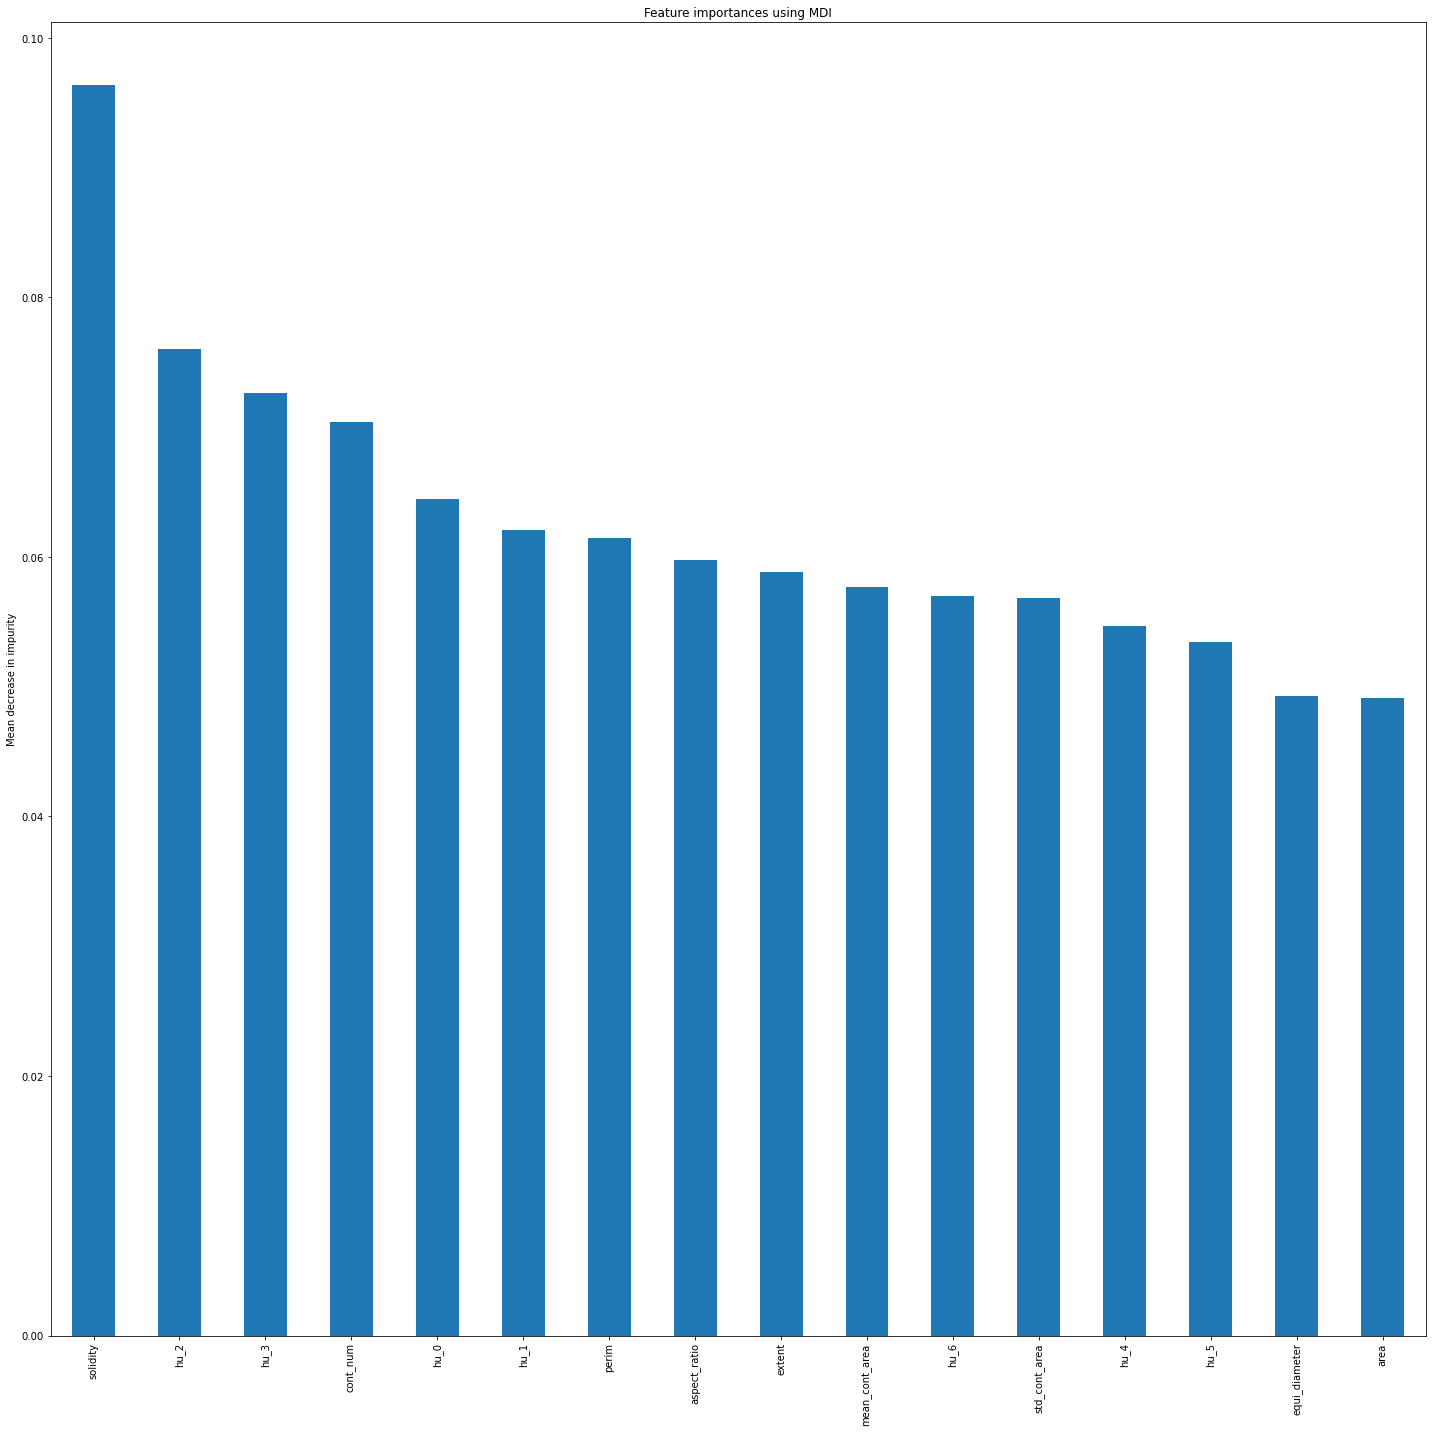

In [7]:
fig, ax = plt.subplots(figsize=(20, 20))
fi_res.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Dimensionality Reduction

In [22]:
data = pd.read_feather('/media/vzalevskyi/DATA/ProjectsData/skin-lesion-cad/data/processed/chall1/train/shape_features.feather')
data['class'] = [1 if 'nev' in n else 0 for n in data['name'].values]
data = data.drop(columns=['name'])


# DROPPING FEATURES
no_lab_features = [x for x in data.columns if 'lab' in x]
data = data.drop(columns=no_lab_features)



all_X = data.drop(columns=['class']).values
all_y = data['class'].values


all_X[np.isnan(all_X)] = 0
all_X[np.isinf(all_X)] = 0

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idxs, test_idxs = next(split.split(all_X, all_y))
X_train, X_test, y_train, y_test  = all_X[train_idxs], all_X[test_idxs], all_y[train_idxs], all_y[test_idxs]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
pca = PCA(n_components=0.99)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# X_train_pca = X_train
# X_test_pca = X_test

print(X_test.shape)
print(X_test_pca.shape)

(4559, 19)
(4559, 11)


In [25]:
svc = SVC(kernel='rbf', probability=True)
svc.fit(X_train_pca, y_train)

y_pred = svc.predict(X_test_pca)

print(classification_report(y_test, y_pred))
print('Confusion Matrix\n',confusion_matrix(y_test, y_pred))
print(f'\nAccuracy {feat_type}-{mask_type}', accuracy_score(y_test, y_pred))
print(f'\nF1-score avg {feat_type}-{mask_type}', f1_score(y_test, y_pred, average='weighted'))

enc = OneHotEncoder()
y_test_oh = enc.fit_transform(y_test.reshape(-1,1)).toarray()
# roc_auc_score_multiclass(svc, X_test_pca, y_test_oh)

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      2241
           1       0.71      0.71      0.71      2318

    accuracy                           0.70      4559
   macro avg       0.70      0.70      0.70      4559
weighted avg       0.70      0.70      0.70      4559

Confusion Matrix
 [[1555  686]
 [ 678 1640]]

Accuracy raw-full_image 0.7008115814871683

F1-score avg raw-full_image 0.7008017896203025
